# <font color='purple'>DM Review: Elastic Nuclear Recoil</font>

Author: Sophia Andaloro
<br>
DOB: 10/27/2020

### <font color='orange'>Intro</font>
Hi, welcome to my tutorial on how DM calculations are made.
This is done initially for Nuclear Recoil (NR) DM, but we will see where it leads us. 
Based on the Lewin/Smith review paper and helped in large part by Jelle Aalber's thesis on the XENON1T experiment. 

Sources: 
1. [Dark matter search with XENON1T, Jelle Aalbers, 2017](https://inspirehep.net/literature/1753515)
2. [Review of mathematics, numerical factors, and corrections for dark matter experiments based on elastic nuclear recoil, Lewin/Smith, 1995](https://inspirehep.net/literature/405551)

--------

In [857]:
import numpy as np
from scipy.special import erf
from scipy.integrate import quad

import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image

Inside the notebook below you'll find some imports and plotting utils, as well as some more basic calculations I made the first time around before I included things like velocity distribution. 
<br>
It may trip an error but it should be ok for this tutorial.

In [2]:
%run dm_basics_utils.ipynb

# Overview

## Outline of goals

We want to:
<br>
- Understand the calculations that go into a WIMP plot 
- Make a calculation quick to get some plots of use. 
- Prepare for our qualifier? ;) 

We need to: 
<br>
- Outline the basic steps to get to the rate and cross-section plots 
- Understand the trends in the lines 
- Follow through the most basic example, then sophisticate our model to include more realistic features (like velocity distribution, form factors...)

# Preamble: 


What we see in WIMP papers are *limit plots*, and that's what we kind of hope to emulate. 
We won't be able to get 100% perfection as the plots are data-driven and depend on background rates, and detector factors that we aren't covering here. 

I hope this gives you some appreciation for how complex these types of analyses are! 
But don't forget, we don't simply get to throw our detector in some minimal-background and spit out this plot, there is so much more that goes into it, and I hope to do more tutorials as I work deeper and deeper into how our experiments can get the "money-shot" plot. :-)

For comparison, let's look at the plot comparing our cross-section for spin-independent DM-nucleon scattering in XENON1T and nT (taken from the wiki blessed plots):

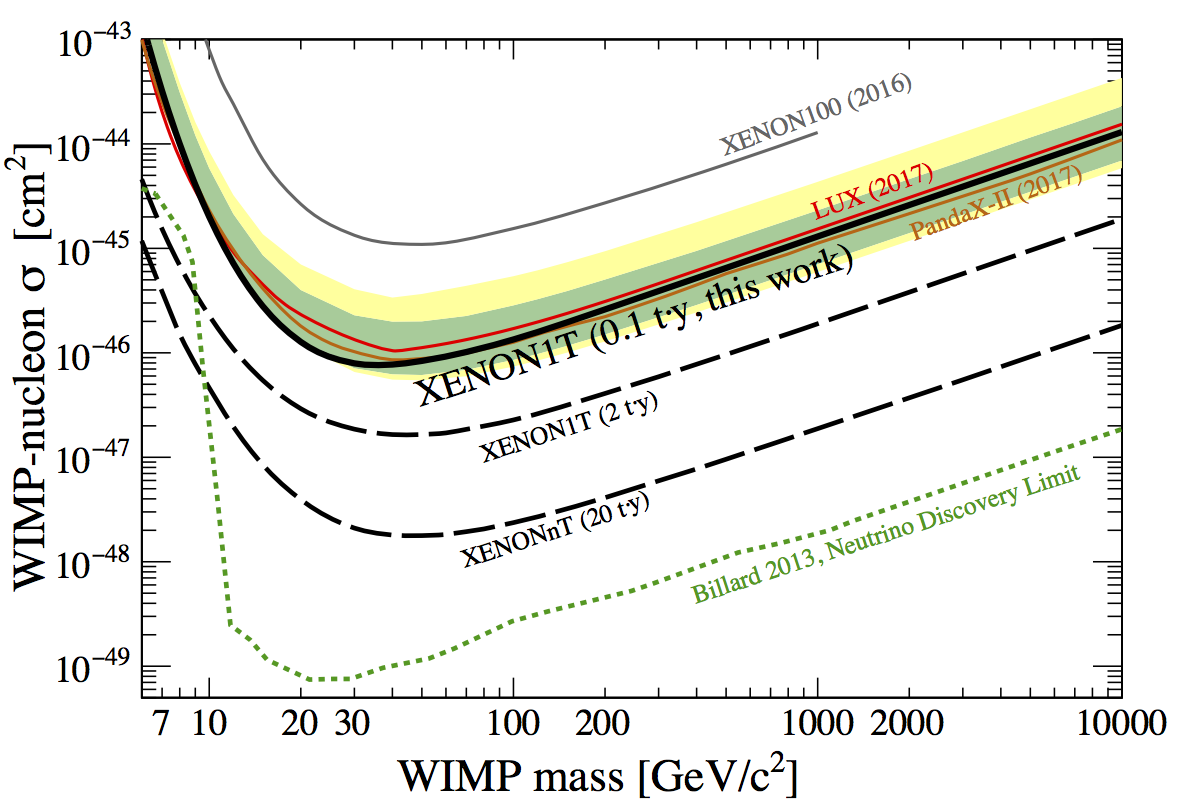

In [856]:
Image(filename='limits_sr0.png') 

# <font color='purple'>Let's Get Started! </font> 

## <font color='blue'> Level 0: The stationary, perfect detector in a uniform field. </font>

The most basic case would be a perfect detector (100% efficiency) in a constant, uniform flux of dark matter particles. We can do some basic particle physics predictions here. Let's start with the most basic PP rate of an interaction of a scattering on a single particle from an incident flux:
$$ r = nv\sigma $$
$r$ ~ $ s^{-1}$, $v$ ~ $ cm*s^{-1}$, $\sigma$ ~ $ cm^{2}$, $n$ ~ $ cm^{-3}$

So to start simple, let's imagine a velocity of 200 km/s, a cross section of σ=10<sup>-40</sup> cm<sup>2</sup>, an energy density of $\rho=0.3 GeV/c^2/cm^{3}$
and a mass of DM of 100 GeV.

Recall:
$$ \rho = m_\chi * n $$ is constant. 

In [858]:
rho = 0.3 # GeV/c2/cm3
m_x = 100 # GeV/c2
n = rho / m_x # number/cm3
sigma = 10**-40 # cm2
v = 200 * 1e5 #cm/s

r = n*sigma*v
print('One DM interaction happens on a single "target" with a frequency of: %.1e Hz'%(r))
print('Which is: %.1e /year'%(r*3600*24*365))

One DM interaction happens on a single "target" with a frequency of: 6.0e-36 Hz
Which is: 1.9e-28 /year


So in this simple model, what if we put a 5000 kg vat of a bunch of targets (Xenon) together, monitor them for a few years? Say some hypothetical scientific committee says we need 100 DM events to happen to declare a discovery. How long will that take? 

In [66]:
m_xe = .129 # kg/mol roughly. 
m_t = 5000 # kg
N_a = 6.02e23
n_target = m_t/m_xe*N_a # number
n_events = 100 
time = n_events / (r*n_target) #seconds

years = time / (3600*24*365)

print('We have to set our perfect detector out for %.2f years.'%(years))

We have to set our perfect detector out for 22.65 years.


That's a long time to wait, and we assumed a perfect detector. 
We could keep playing with this pretty fun equation but let's get more technical. 

---------

# <font color='blue'> Level 1: Experimental Considerations, Differential Rates </font>

We'll focus on non-directional detectors, like XENONnT.
We can treat equation 0.1 above now in differential form, making some subtitutions on the parameters of interest:

$$ \frac{dR}{dE_R} = \frac{\rho}{m_\chi} \frac{1}{m_N} \int{dv f(v)*v*\frac{d\sigma}{dE_R}(v)} $$ (1.1)

Some caveats: not all velocities will be able to create a recoil energy of E<sub>R</sub> so we code that into the differential cross section. 

The units are: $\frac{dR}{dE_R}\sim kg^{-1}yr^{-1}keV^{-1}$, where we make some conversions of standard use to get those units. 

So let's just start plotting, right? Well, we need to figure out equation 1.1 (above) in terms of things we actually measure now. 
We know we plot the DM-nucleon cross section versus the mass, i.e. $\sigma_n$ versus $m_\chi$

## <font color='blue'> Level 2: Velocity Distribution <font>

We could begin by doing some constant velocity distribution and making the cross-section constant but I don't think it's too much more confusing for us to look at using what's known as the **standard halo model**, i.e. the following distribution:

$$ F_g(\bf{v_g}) =
    \begin{cases}
      k(\frac{1}{\sqrt{\pi}v_0})^3 e^{-(v_g/v_0)^2} & v_g < v_{esc}\\
      0 & v_g \geq v_{esc}
    \end{cases}      $$
2.1 

$\bf{v_g}$ is our velocity in the galactic rest frame.
$v_0$ is the most probable speed of the DM particles. 
$v_{esc}$ is the escape speed of the galaxy.
$k$ is a normalization constant given by: 
$$k = \text{erf}(v_{esc}/v_0) - \frac{2}{\sqrt{\pi}}\frac{v_{esc}}{v_0} \text{exp}(-(v_{esc}/v_0)^2)$$
2.2

and we take that as just a given here though it can be derived if we cared to.

You'll notice this is the Maxwellian distribution with the velocity cut off at $v_{esc}$. 
We can figure out $v_0$ using thermodynamic properties (assuming the DM was created in freeze-out mode, I think, so it is cold today):

$$ v_0 = \sqrt{2 k_B T / m}$$
2.3
<br>
It seems there are other models which are more sophisticated that gives us the right number, maybe something to look into? 

In [863]:
k_B = 8.617e-5 # eV/K 
T = 2.7 # K
m = 100e9 # 100 GeV 
c = 3e5 #km/s 
v0 = np.sqrt(2 * k_B * T / m) * c
v0

0.020464266417343183

Next, let's consider the velocity of earth in this field, $\bf{v_E}$.
We're going to ignore higher-order effects like annual modulation of earth within the galaxy. So then what speed do we observe of the particles, i.e. speed $v$ as seen by our detector? 
$$ v_g = v^2 + v_E^2 - 2v_Ev_g\text{cos}(\pi - \theta)$$
2.4

where $\theta$ is our angle between **v** and **v<sub>E</sub>**

Plugging this into our equation for $f(v)$:
$$ f(v) = \int_0^{2\pi}d\phi \int_0^{\pi}d\theta v^2 \text{sin}(\theta)F_g(v_g) $$
2.5

The integral above is 0 if $ v > v_E + v_esc $, as the DM wouldn't be in our galaxy today.

We can do a fancy change of variables that Jelle does in his thesis, considering the cutoff above and the kinematics of 2.4 to get the integral rewritten: 

$$ f(v) = \frac{kv}{\sqrt\pi v_0 v_E} [\text{exp}(-v-v_E)^2/v_0^2 - \text{exp}(v^2+v_E^2+2vv_Ex_{max}(v))/v_0^2) ] $$ 
2.6

Let's put in some constants and see what this distribution of DM velocities looks like. 

In [87]:
rho = 0.3 # GeV/c^2/cm^3
v_0 = 220 # km/s
v_E = 232 # km/s
v_esc = 544 # km/s
pi = np.pi

In [394]:
k = erf(v_esc / v_0) - 2/np.sqrt(pi) * v_esc/v_0 * np.exp(-(v_esc/v_0)**2)

In [136]:
v = np.linspace (1, 1000, 300) #km/s

In [413]:
def f(vel):
    x_max = np.minimum(vel, 
                  (v_esc**2 - v_E**2 - vel**2) / (2 * v_E * vel))
    f = k * vel / (np.sqrt(pi) * v_0 * v_E) * (
        np.exp(-(vel-v_E)**2 / v_0**2) - np.exp(-(vel**2 + v_E**2 + 2*vel*v_E * x_max) / v_0**2)
    )
    v_mask = np.where(vel < v_esc + v_E, f, 0)
    return v_mask

In [ ]:
# Play w escape velocity - not that well known 

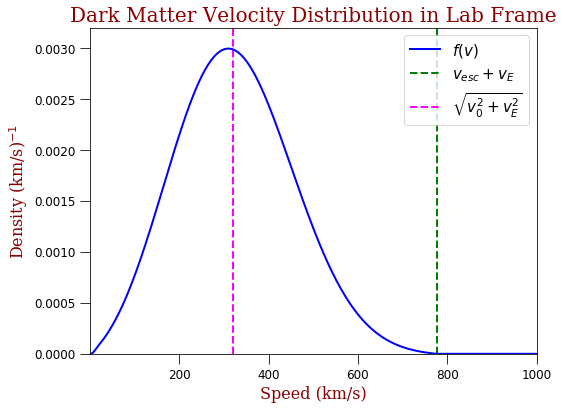

In [139]:
plt.figure(figsize = (8,6))
plt.plot(v, f(v), 
         c='b', linewidth = 2, 
        label = '$f(v)$')
plt.vlines(v_esc + v_E, 0, 0.0032, 
           color='g', linewidth=2, linestyle='--', 
          label = '$v_{esc} + v_E$')
plt.vlines(np.sqrt(v_0**2 + v_E**2), 0, 0.0032, 
           color='magenta', linewidth=2, linestyle='--', 
          label = '$\sqrt{v_0^2 + v_E^2}$')

plt.margins(0.0)
plt.ylim(0, 0.0032)
plt.xlabel('Speed (km/s)', fontdict = font_small)
plt.ylabel('Density (km/s)$^{-1}$', fontdict = font_small)
plt.legend(fontsize=15)
plt.title('Dark Matter Velocity Distribution in Lab Frame', fontdict = font_medium)
plt.show()
# f(v)

--------

## <font color='blue'> 3: Scattering <font>
The next piece of the puzzle is figuring out our recoil energies possible: i.e. to get dsigma.
Luckily, we're dealing with non-relativistics for traditional WIMPs so our kinematics in the COM frame is easy:

$$ E_R(v) = \frac{\mu_N^2 v^2}{m_N} (1-\text{cos}(\theta))$$
3.1

I leave this to you to prove but it should be easy!
Taking it at face-value, where $\theta$ is our scattering angle and $\mu$ the reduced mass. 

We know from physics I the most energy transfer happens when we have a linear collision (the WIMP goes back the way it came from) so the maximum energy we can transfer to the nucleus is: 

$$ E_{max}(v) = \frac{2\mu_N^2 v^2}{m_N} $$
3.2 

If we were scattering billiard balls, all angles $\theta$ are equally likely, so we can easily find the means. 
That'll be shown below. 

**Note we are just considering for now nuclear recoils!**

We need to pick a target nucleus at this point, so we consider $m_N = 129 * 0.932$  GeV 

In [323]:
A = 129 
m_N = A * .932 # GeV 
m_x = np.logspace(-1, 4, 100)
mu = m_N*m_x / (m_N + m_x) # GeV

In [180]:
v_mean = np.sqrt(v_0**2 + v_E**2) / 3e5 # in c
v_max = (v_esc + v_E) / 3e5 # in c

In [181]:
E_max = 2* mu**2 * v_max**2 / m_N * 1e6 # in keV

In [191]:
E_mean = 1/2 * mu**2 * v_mean**2 / m_N * 1e6 # in keV

In [199]:
E_r = 2/pi *  mu**2 * np.mean(v/3e5)**2 / m_N * 1e6 

This is a bit rough as I'm not doing a full-out mean sampling equation on our velocity distribution but to be honest it only gets us off by a factor of about 2 so our order of magnitude is roughly similar.

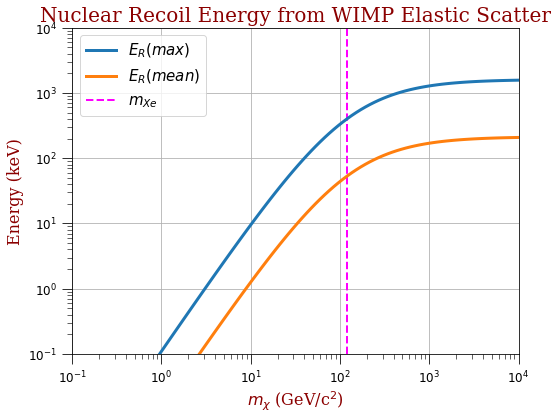

In [206]:
plt.figure(figsize=(8,6))
plt.plot(m_x, E_max, 
        linewidth=3, 
        label='$E_R (max)$')
plt.plot(m_x, E_r, 
        linewidth=3, 
        label='$E_R (mean)$')
plt.vlines(m_N, 1e-1, 1e4, 
           linestyle='--', linewidth=2, 
          color='magenta', label='$m_{Xe}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$m_\chi$ (GeV/c$^2$)', fontdict = font_small)
plt.ylabel('Energy (keV)', fontdict = font_small)
plt.legend(fontsize=15)
plt.title('Nuclear Recoil Energy from WIMP Elastic Scatter', fontdict = font_medium)
plt.margins(0)
plt.grid(True, which='major')
plt.xlim(1e-1,1e4)
plt.ylim(1e-1, 1e4)
plt.show()

This is just for coherent elastic scattering with a nucleus. We will have to make some changes later to look at DM-nucleon scattering but let's consider this for now.

------

## <font color='blue'> 4. Form Factor for Elastic Scattering <font>
We're just considering Elastic DM-nucleus scattering, so we can use the nice form factor for that process: 

$$ \frac{d\sigma}{dE_R}(v) = 
    \begin{cases}
      \sigma_{N,0} F(E_R)^2 / E_{max}(v) & E_R < E_{max} \\
      0 & else
    \end{cases}      $$
    4.1

Why'd we do this?
Well, even if you're considering no form factor, it breaks up the dependence on the energy away from your cross section. 
We know F(0) = 1 (i.e. the nucleus sees a ball coming at it and vice versa).


### <font color='orange'> Spin-Independent Scattering: </font>
If we consider a scalar WIMP in a neutral-current interaction, the spin of the nucleon it interacts with should be inconsequential, i.e. it's a spin-independent interaction. 
<br>
In reality we have to consider the spin-independent and spin-dependent terms like so: 
$$ \frac{d\sigma}{dE_R}(v) = 
      \frac{1}{E_{max}}(\sigma_{0}^{SI}F_{SI}^2 + \sigma_{0}^{SD}F_{SD}^2)
$$
4.2

In 4.2, only nuclei with non-zero J contribute to the SD coupling.

In [ ]:
# Check form factor w/ wiki 

We look at Spin-independent scattering because with Xenon the spin is so small compared to the number of nuclei that the spin-independent interaction is a much stronger constraint.  Our form factor is: 

$$ 
F_{SI} = \frac{3j_1(\hat q r)}{\hat q r} e^{-(\hat q s)^2 / 2}
\\
\text{where } \hat q = q/(\hbar c) \text{ is the momentum transfer from } q = \sqrt{2E_R m_N}
\\
r^2 = (1.23A^{1/3} - 0.6)^2 \text{fm}^2 + \frac{7}{3}\pi^2((0.52 \text{fm})^2 - 5s^2
\\
s = 0.9\text{fm}
$$

What does this do? At high q, it suppresses the cross-section by up to $10^{-8}$ for xenon.

In [220]:
hbar = 197 #MeV* fm 

In [229]:
def j1(z):
    return np.sin(z)/z**2 - np.cos(z)/z

In [256]:
def F_SI(E_R, A=129): # E_r in keV
    m_N = A * 0.932 # GeV
    q = np.sqrt(2*E_R*m_N) # MeV
    qhat = q/hbar # 1/fm
    s=0.9 # fm 
    
    r = np.sqrt( (1.23*A**(1/3) - 0.6)**2 +
                7/3 * pi**2 * 0.52**2 -
                5 * s**2
    )
    
    exp = np.exp(-(qhat*s)**2/2)
    
    F = 3*j1(qhat*r)/(qhat*r) * exp
    return F

In [259]:
x = np.linspace(1,100)
F = F_SI(x) 

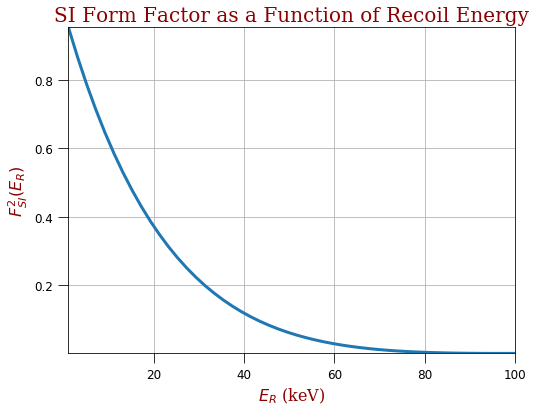

In [266]:
plt.figure(figsize=(8,6))
plt.plot(x, F**2, 
         linewidth=3, 
        label='$F_{SI}^2(E_R)$')
# plt.yscale('log')
plt.ylabel('$F_{SI}^2(E_R)$', fontdict = font_small)
plt.xlabel('$E_R$ (keV)', fontdict = font_small)
# plt.legend(fontsize=15)
plt.title('SI Form Factor as a Function of Recoil Energy', fontdict = font_medium)
plt.margins(0)
plt.grid(True, which='major')
# plt.xlim(1e-1,1e4)
# plt.ylim(1e-1, 1e4)
plt.show()

### Takeaways 
- We have the highest contribution at low recoil energies
- As recoil energy increases, our form factor decreases which will contribute less to the cross-section

------

# <font color='blue'> 5. DM-nucleon Expressions </font>

Since DM searches happen in a number of ways, we get our limit plots by considering DM-nucleon scattering cross sections, which scales our amplitude by A, so our cross-section by $A^2$.
This amounts to:

$$
\sigma_{N,0,SI} = \sigma_{n,SI} \frac{\mu_N^2}{\mu_n^2} A^2
$$
where the $\mu$s are just our reduced masses. 

In [269]:
m_n = 0.935 #average. 

In [742]:
f_n = 1e-10 # MeV^2 #DM coupling to a neutron, where we here approximate it to be the same for a proton

In [749]:
def sigma_n(m_x, f_n=1e-11):
    mu_N = m_N*m_x / (m_N + m_x)
    mu_n = m_n * m_x / (m_n + m_x)
    sigma_n = (4*hbar**2/pi) *mu_n**2 * f_n**2 * 1e-13**2 #MeV^4cm^2 f^2
    return sigma_n

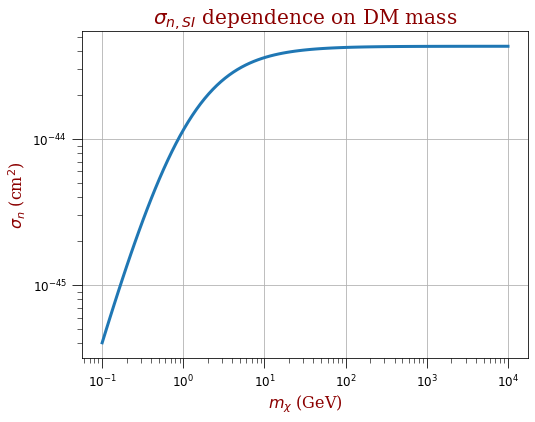

In [750]:
plt.figure(figsize=(8,6))
plt.plot(m_x, sigma_n(m_x), linewidth=3)
plt.xscale('log')
plt.yscale('log')

plt.xlabel('$m_{\chi}$ (GeV)', fontdict = font_small)
plt.ylabel('$\sigma_n$ (cm$^2$)', fontdict = font_small)
# plt.legend(fontsize=15)
plt.title('$\sigma_{n,SI}$ dependence on DM mass', fontdict = font_medium)
# plt.margins(0)
plt.grid(True, which='major')
# plt.xlim(1e-1,1e4)
# plt.ylim(1e-1, 1e4)
plt.show()

------

#  <font color='blue'> 6. What we measure </font>

Let's go back to equation 1.1:

$$ \frac{dR}{dE_R} = \frac{\rho}{m_\chi} \frac{1}{m_N} \int{dv f(v)*v*\frac{d\sigma}{dE_R}(v)} $$ (1.1)

$$ \frac{d\sigma}{dE_R}(v) = 
    \begin{cases}
      \sigma_{N,0} F(E_R)^2 / E_{max}(v) & E_R < E_{max} \\
      0 & else
    \end{cases}      $$
    4.1

In [872]:
rho = 0.3 # GeV/cm^3
m_x = np.logspace(-1, 4, 100) # GeV 
m_x = 500 #For now just a placeholder to avoid hangups in vectors 
m_N = A * .932 # GeV 
def mu_N(m_x):
    return m_N*m_x / (m_N + m_x)
def mu_n(m_x):
    return m_n * m_x / (m_n + m_x)
v = np.linspace(1,1000,1000)

In [873]:
def sigma_N0(m_x):
    return sigma_n(m_x) * mu_N(m_x)**2 / mu_n(m_x)**2 * A**2

In [874]:
def E_max(v, m_x):
    Emax = 2* mu_N(m_x)**2 * (v/3e5)**2 / m_N * 1e6 # in keV
    return Emax

In [875]:
def dsigma_dEr(v, E_R=15, m_x=100):
    A = sigma_N0(m_x) * F_SI(E_R)**2 / E_max(v, m_x)
    B = 0 
    dsig_dEr = np.where(E_R<E_max(v, m_x), A, B)
    return dsig_dEr

In [876]:
def integrand(v, E_R=15, m_x=100):
    integrand = f(v) * v * dsigma_dEr(v, E_R=E_R, m_x=m_x)
    return integrand

In [877]:
def dR_dER(integral, m_x=m_x):
    result = rho/m_x * 1/m_N * integral
    return result

In [878]:
E_Rs = np.logspace(-1,3, 100)

In [879]:
def diff_rate(E_Rs, m_DM):
    integrals=[]
    for E_R in E_Rs:
        integral = np.sum(integrand(v, E_R, m_DM)) # quad(integrand, 1, 1000, args=(E_R, m_DM))[0]
        integrals.append(integral)
    integrals = np.asarray(integrals)    
    
    
    diff_rate = dR_dER(integrals, m_DM)# /s /keV km/cm /Gev/c^2
    dr_dEr = diff_rate * 1e5 #cm/km, now in /s /keV /GeV/c^2 of target 
    dr_dEr = dr_dEr * 3600 * 24 * 365.25 # now in /keV*year /GeV/c^2 of target 
    dr_dEr = dr_dEr / 1.67e-27 # now in /keV*year*kg_target
    
    return dr_dEr

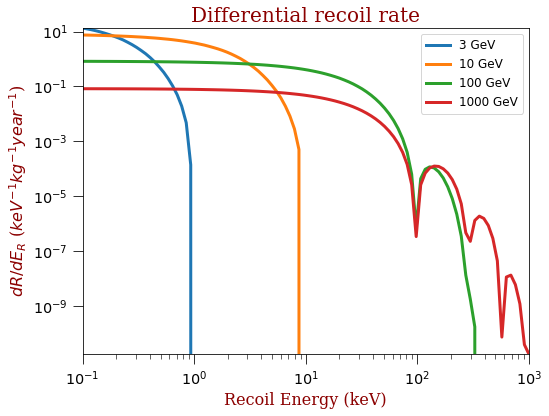

In [880]:
plt.figure(figsize=(8,6))
m_d = [3, 10, 100, 1000]
for i, mass in enumerate(m_d):
    plt.plot(E_Rs, diff_rate(E_Rs, m_DM=mass), linewidth=3, label='%.0f GeV'%(mass))

plt.yscale('log')
plt.xscale('log')
plt.title('Differential recoil rate', fontdict=font_medium)
plt.ylabel('$dR/dE_R$ ($keV^{-1}kg^{-1}year^{-1}$)', fontdict=font_small)
plt.xlabel('Recoil Energy (keV)', fontdict=font_small)
plt.tick_params(axis='x',which='both', labelsize='x-large', )
plt.tick_params(axis='y',which='both', labelsize='x-large', )
# plt.ylim((1e-5,1e-2))
plt.legend(fontsize=12)
plt.margins(0)
plt.show()

### Investigating above

There's a ton of nuance above, and I have kind of a more basic version below that I hope to have done, but this is the cooler of the two. 

Let's understand all the trends.
- There's bumps at high enough energies and masses, when we allow our heavier candidates to see nuclear structure. 
- The recoil energy eventually is not possible to be reached by certain masses anymore, so drops off at E_max. 
- As the mass increases, our overall maximum amplitude we see on the graph decreases: there are less particles so less flux, therefore less rate of scattering. 

#  <font color='blue'> 7. Total rate </font>

Now we only need to integrate the above from our energy threshold onward to get the total WIMP rate!

In [881]:
E_th=1
E_th = 5
m_x = np.logspace(-1,4,100)

def calc_total_rate(E_th, m_x, ):
    rates = []
    for m_DM in m_x:
        E_Rs = np.logspace(-1,3, 1000)
        ERB = np.broadcast_to(E_Rs, (v.shape[0], E_Rs.shape[0])).T
        integ = integrand(v, ERB, m_DM)
        integrals = np.sum(integ, axis=1)
        diff_rate = np.asarray(dR_dER(integrals, m_DM))
        dr_dEr = diff_rate * 1e5 #cm/km, now in /s /keV /GeV/c^2 of target 
        dr_dEr = dr_dEr * 3600 * 24 * 365.25 # now in /keV*year /GeV/c^2 of target 
        dr_dEr = dr_dEr / 1.67e-27 # now in /keV*year*kg_target
        total_rate = np.sum(dr_dEr[np.argwhere(E_Rs>E_th)])
        rates.append(total_rate)
    return rates

In [882]:
rates_p1keV = calc_total_rate(.1, m_x)
rates_1keV = calc_total_rate(1, m_x)
rates_5keV = calc_total_rate(5, m_x)

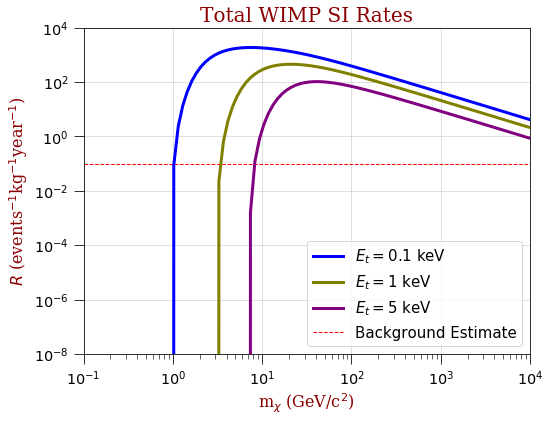

In [883]:
plt.figure(figsize=(8,6))

plt.plot(m_x, rates_p1keV, 
         c='blue', linewidth=3, 
         label= r'$E_{t} = 0.1 $ keV')
plt.plot(m_x, rates_1keV, 
         c='olive', linewidth=3, 
         label= r'$E_{t} = 1 $ keV')
plt.plot(m_x, rates_5keV, 
         c='purple', linewidth=3, 
         label= r'$E_{t} = 5 $ keV')

plt.hlines(0.1, 1e-1, 1e4, color='red', linewidth=1, 
          linestyle = '--', label='Background Estimate')

plt.legend(fontsize=15)
plt.margins(0)


plt.yscale('log')
plt.xscale('log')
plt.title('Total WIMP SI Rates', fontdict=font_medium)
plt.ylabel('$R$ (events$^{-1}$kg$^{-1}$year$^{-1}$)', fontdict=font_small)
plt.xlabel('m$_\chi$ (GeV/c$^2$)', fontdict=font_small)
plt.tick_params(axis='x',which='both', labelsize='x-large', )
plt.tick_params(axis='y',which='both', labelsize='x-large', )

plt.ylim(1e-8,1e4)
plt.grid(True, which='major', alpha=0.5)
# plt.gca().invert_yaxis()
plt.show()

##  <font color='orange'> To include bg subtraction or not? </font>

In [884]:
rates_p1keV = np.asarray(rates_p1keV) - 0.1
rates_1keV = np.asarray(rates_1keV) - 0.1
rates_5keV = np.asarray(rates_5keV) - 0.1

In [885]:
rates_p1keV = np.where(rates_p1keV>0, rates_p1keV, 0)
rates_1keV = np.where(rates_1keV>0, rates_1keV, 0)
rates_5keV = np.where(rates_5keV>0, rates_5keV, 0)

In [886]:
m_xnt = 6000. #kg
xent_rate = rates_1keV * 20000 # (something like 20ty)
xe1t_rate = rates_1keV * 2000 # (2 ton years)

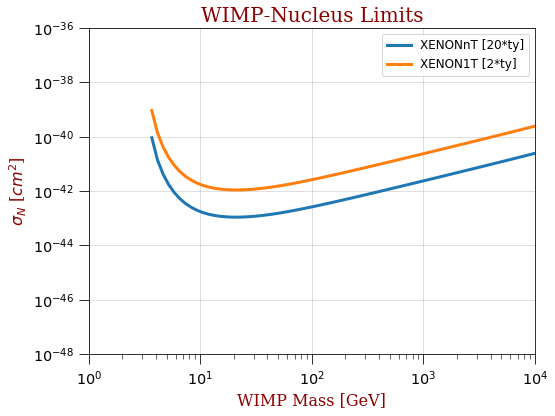

In [887]:
plt.figure(figsize=(8,6))
# for i, mass in enumerate(m_d):
#     plt.plot(E_r[:,i], dRdE0r[:,i], linewidth=3, label='%.0f GeV'%(mass))
plt.plot(m_x,1/ xent_rate * 10**(-36), linewidth=3, label='XENONnT [20*ty]')
plt.plot(m_x,1/ xe1t_rate * 10**(-36), linewidth=3, label='XENON1T [2*ty]')

plt.xscale('log')
plt.yscale('log')
plt.title('WIMP-Nucleus Limits', fontdict=font_medium)
plt.ylabel('$\sigma_{N}$ [$cm^2$]', fontdict=font_small)
plt.xlabel('WIMP Mass [GeV]', fontdict=font_small)

plt.ylim((1e-48, 1e-36))
plt.xlim((1e-0,1e4))
plt.tick_params(axis='x',which='both', labelsize='x-large', )
plt.tick_params(axis='y',which='both', labelsize='x-large', )

plt.grid(True, which='major', alpha=0.5)
# plt.xticks(xt, xt * 10**(-36)) # in cm^2 

plt.legend(fontsize=12)
# plt.margins(0)
plt.show()

Since DM searches happen in a number of ways, we get our limit plots by considering DM-nucleon scattering cross sections, which scales our amplitude by A, so our cross-section by $A^2$.
This amounts to:

$$
\sigma_{N,0,SI} = \sigma_{n,SI} \frac{\mu_N^2}{\mu_n^2} A^2
$$
where the $\mu$s are just our reduced masses. 

In [848]:
m_xnt = 6000. #kg
xe1t_rate = rates_5keV * 2000 # (something like 20ty)
xent_rate_5 = rates_5keV * 20000 # (2 ton years)
xent_rate_1 = rates_1keV * 20000 # (2 ton years)

sigma_n_SI_1t =  1/ xe1t_rate  / A**2 * 10**(-36)
sigma_n_SI_nt_1 =  1/ xent_rate_1  / A**2 * 10**(-36)
sigma_n_SI_nt_5 =  1/ xent_rate_5  / A**2 * 10**(-36)

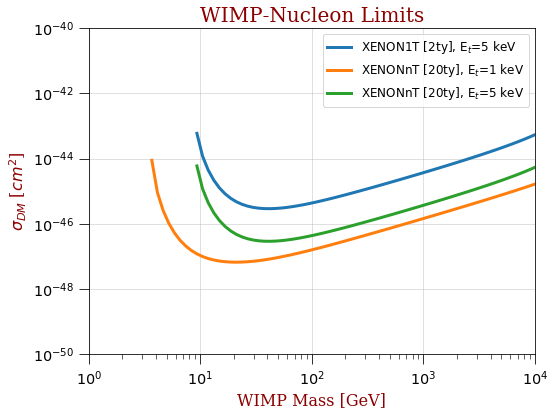

In [853]:
plt.figure(figsize=(8,6))
# for i, mass in enumerate(m_d):
#     plt.plot(E_r[:,i], dRdE0r[:,i], linewidth=3, label='%.0f GeV'%(mass))
plt.plot(m_x,sigma_n_SI_1t, linewidth=3, label='XENON1T [2ty], E$_t$=5 keV')
plt.plot(m_x,sigma_n_SI_nt_1 , linewidth=3, label='XENONnT [20ty], E$_t$=1 keV')
plt.plot(m_x,sigma_n_SI_nt_5 , linewidth=3, label='XENONnT [20ty], E$_t$=5 keV')

plt.xscale('log')
plt.yscale('log')
plt.title('WIMP-Nucleon Limits', fontdict=font_medium)
plt.ylabel('$\sigma_{DM}$ [$cm^2$]', fontdict=font_small)
plt.xlabel('WIMP Mass [GeV]', fontdict=font_small)

plt.ylim((1e-50, 1e-40))
plt.xlim((1e-0,1e4))
plt.tick_params(axis='x',which='both', labelsize='x-large', )
plt.tick_params(axis='y',which='both', labelsize='x-large', )

plt.grid(True, which='major', alpha=0.5)
# plt.xticks(xt, xt * 10**(-36)) # in cm^2 

plt.legend(fontsize=12)
# plt.margins(0)
plt.show()

<font color='green'> **Why's it higher than what we quote? Because we haven't considered the background model!**</font>

We typically make these limit plots for rates above background, with a 90% confidence limit. 
<br>
We can use poisson statistics to figure out that, or just subtract a background rate of say 0.1 events/kg/year. 

-------

#  <font color='red'> Words of caution / TODO list for a "real" plot </font>

Our model above is missing a couple of elements that might affect exact numbers. 
- I threw in just some standard-ish numbers for background modeling and the coupling constant. 
- This is a spin-independent model.
- You can play around and mess with various parameters, but we're just trying to understand trends here. 
- I didn't use Poisson statistics, that's weird as I thought it would come into play. 

## Exercises:

- Repeat for Spin-dependent
- Try different form factors 
- Try various background spectra, detector properties (drift field?) 
- Try different scattering (inelastic, Bremmstrahlung) 